In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
import os
import random
from tqdm import tqdm
from PIL import Image
import math
import json
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import torch.quantization
import torchvision.transforms.functional as TF
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
import pandas as pd

In [2]:
from google.colab import drive
drive.mount(('/content/drive'))

import tarfile

path = "/content/drive/MyDrive/LaPa.tar.gz"
extract_path = "/tmp"

# Open the tar.gz file
with tarfile.open(path, "r:gz") as tar:
    # Extract all contents to /tmp
    tar.extractall(path=extract_path)

Mounted at /content/drive


In [3]:
# Define paths to the subfolders
train_path = os.path.join("/tmp/LaPa/train")
test_path = os.path.join("/tmp/LaPa/test")
validation_path = os.path.join("/tmp/LaPa/val")

# Define paths to the images subfolder in each dataset split
train_images_path = os.path.join(train_path, "images")
test_images_path = os.path.join(test_path, "images")
validation_images_path = os.path.join(validation_path, "images")

# Define paths to the landmarks subfolder in each dataset split
train_landmarks_path = os.path.join(train_path, "landmarks")
test_landmarks_path = os.path.join(test_path, "landmarks")
validation_landmarks_path = os.path.join(validation_path, "landmarks")

# Define paths to the labels subfolder in each dataset split
train_labels_path = os.path.join(train_path, "labels")[:1500]
test_labels_path = os.path.join(test_path, "labels")[:400]
validation_labels_path = os.path.join(validation_path, "labels")[:200]


In [4]:
# Save checkpoint
def save_checkpoint(state,epoch,filename='RESUNET.weights.pth.tar_'):
    print('Saving weights-->')
    torch.save(state,filename+str(epoch))

# Load checkpoint
def load_checkpoint(filename,model,optim,device):
    print('Loading weights-->')
    checkpoint = torch.load(filename, map_location=device)
    #checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['state_dict'])
    optim.load_state_dict(checkpoint['optimizer'])

    # Move the model and optimizer to the correct device
    model.to(device)
    for state in optimizer.state.values():
        if isinstance(state, torch.Tensor):
            state.data = state.data.to(device)
            if state._grad is not None:
                state._grad.data = state._grad.data.to(device)



In [5]:
def my_img_mask_transforms(image, mask):
    resize = transforms.Resize((512, 512))
    totensor = transforms.ToTensor()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    image = resize(image)
    mask = resize(mask)

    seed = 2024
    random.seed(seed)
    torch.manual_seed(seed)

    if random.random() > 0.5:
          angle = random.randint(-30, 30)
          image = TF.rotate(image, angle)
          mask = TF.rotate(mask, angle)

    if random.random() > 0.5:
        image = TF.hflip(image)
        mask = TF.hflip(mask)

    # if random.random() > 0.5:
    #     image = TF.vflip(image)
    #     mask = TF.vflip(mask)

    image = totensor(image)
    image = normalize(image)
    mask = torch.tensor(np.array(mask), dtype=torch.float32)

    return image, mask



class Lapa(Dataset):
    def __init__(self, images_dir, masks_dir, size):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = os.listdir(images_dir)[:size]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_path = os.path.join(self.images_dir, self.image_files[index])
        mask_path = img_path.replace("images", "labels").replace("jpg", "png")

        # Open image
        image = Image.open(img_path).convert("RGB")

        # Open mask and convert to PIL Image
        mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask_img = Image.fromarray(cv2.resize(mask_img, (512, 512)))


        image, mask_img = my_img_mask_transforms(image, mask_img)

        # Split the masks
        binary_masks = []
        for class_value in range(0, 11):
            binary_mask = (mask_img == class_value).float()
            binary_masks.append(binary_mask)

        return image, torch.stack(binary_masks, dim=0)

In [6]:
train_dataset = Lapa(train_images_path,
                    train_labels_path,
                    1200)

val_dataset = Lapa(validation_images_path,
                   validation_labels_path,
                   210)

test_dataset = Lapa(test_images_path,
                   test_labels_path,
                   210)


Image 0 is tensor: True


Image 1 is tensor: True


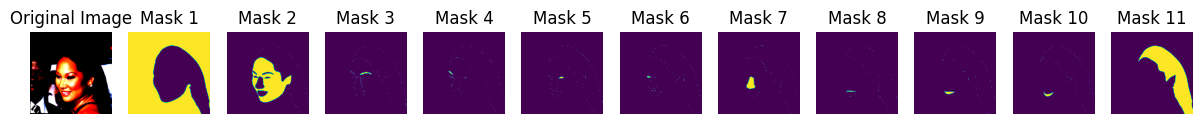

Image 2 is tensor: True


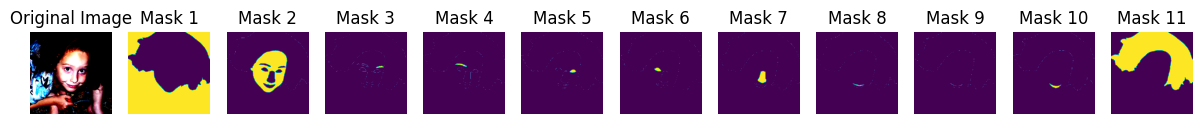

Image 3 is tensor: True


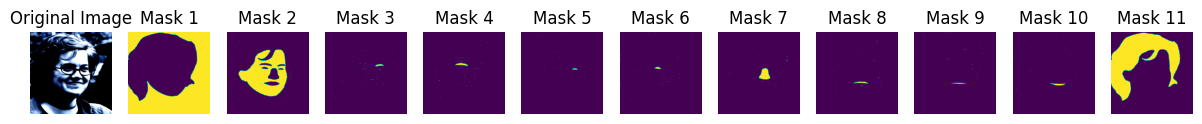

Image 4 is tensor: True


In [7]:
for i in range(5):  # Change the range as needed
    t = train_dataset[i]
    img = np.array(t[0].permute(1, 2, 0))
    print(f"Image {i} is tensor: {isinstance(t[1], torch.Tensor)}")
    mask = np.array(t[1])

    num_masks = mask.shape[0]
    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 15))

    # Display the original image
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Display each mask
    for m in range(num_masks):
        axes[m + 1].imshow(mask[m])
        axes[m + 1].set_title(f'Mask {m + 1}')
        axes[m + 1].axis('off')

    plt.show()

In [8]:
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [9]:
def print_masks_batch0(image, mask, pred, num_masks, epoch, batch, save_dir="/content/drive/MyDrive/masks_batch0"):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        num_masks = 11
        fig, axes = plt.subplots(1, num_masks, figsize=(15, 15))
        fig1, axes1 = plt.subplots(1, num_masks, figsize=(15, 15))
        fig2, axes2 = plt.subplots(1, 3, figsize=(12, 4))

        # Display each mask
        for m in range(num_masks):
            axes[m].imshow(mask[0][m].cpu())
            axes[m].set_title(f'Mask {m + 1}')
            axes[m].axis('off')

        for m in range(num_masks):
            axes1[m].imshow(pred[0][m].detach().cpu().numpy())
            axes1[m].set_title(f'PredMask {m + 1}')
            axes1[m].axis('off')

        colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors
        # Create combined masks with different colors
        combined_mask = np.zeros((512, 512, 3))
        combined_pred = np.zeros((512, 512, 3))

        for m in range(num_masks):
            color = colors(m)[:3]  # Get RGB values from colormap
            combined_mask += np.stack([mask[0, m].cpu().numpy()] * 3, axis=-1) * color
            combined_pred += np.stack([pred[0, m].detach().cpu().numpy()] * 3, axis=-1) * color

        axes2[0].imshow(np.array(image[0].permute(1, 2, 0).cpu()))
        axes2[0].set_title('Image')
        axes2[0].axis('off')

        axes2[1].imshow(combined_mask)
        axes2[1].set_title('Combined Ground Truth Masks')
        axes2[1].axis('off')

        axes2[2].imshow(combined_pred)
        axes2[2].set_title('Combined Predicted Masks')
        axes2[2].axis('off')

        # Save the figures
        fig.savefig(f'{save_dir}/RESUNET_0masks_epoch{epoch}_batch{batch}.png')
        fig1.savefig(f'{save_dir}/RESUNET_0pred_masks_epoch{epoch}_batch{batch}.png')
        fig2.savefig(f'{save_dir}/RESUNET_0combined_masks_epoch{epoch}_batch{batch}.png')

        plt.show()
        plt.close(fig)
        plt.close(fig1)
        plt.close(fig2)

In [10]:
def print_masks_batch1(image, mask, pred, num_masks, epoch, batch, save_dir="/content/drive/MyDrive/masks_batch1"):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        num_masks = 11
        fig, axes = plt.subplots(1, num_masks, figsize=(15, 15))
        fig1, axes1 = plt.subplots(1, num_masks, figsize=(15, 15))
        fig2, axes2 = plt.subplots(1, 3, figsize=(12, 4))

        # Display each mask
        for m in range(num_masks):
            axes[m].imshow(mask[1][m].cpu())
            axes[m].set_title(f'Mask {m + 1}')
            axes[m].axis('off')

        for m in range(num_masks):
            axes1[m].imshow(pred[1][m].detach().cpu().numpy())
            axes1[m].set_title(f'PredMask {m + 1}')
            axes1[m].axis('off')

        colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors
        # Create combined masks with different colors
        combined_mask = np.zeros((512, 512, 3))
        combined_pred = np.zeros((512, 512, 3))

        for m in range(num_masks):
            color = colors(m)[:3]  # Get RGB values from colormap
            combined_mask += np.stack([mask[1, m].cpu().numpy()] * 3, axis=-1) * color
            combined_pred += np.stack([pred[1, m].detach().cpu().numpy()] * 3, axis=-1) * color

        axes2[0].imshow(np.array(image[1].permute(1, 2, 0).cpu()))
        axes2[0].set_title('Image')
        axes2[0].axis('off')

        axes2[1].imshow(combined_mask)
        axes2[1].set_title('Combined Ground Truth Masks')
        axes2[1].axis('off')

        axes2[2].imshow(combined_pred)
        axes2[2].set_title('Combined Predicted Masks')
        axes2[2].axis('off')

        # Save the figures
        fig.savefig(f'{save_dir}/RESUNET_1masks_epoch{epoch}_batch{batch}.png')
        fig1.savefig(f'{save_dir}/RESUNET_1pred_masks_epoch{epoch}_batch{batch}.png')
        fig2.savefig(f'{save_dir}/RESUNET_1combined_masks_epoch{epoch}_batch{batch}.png')

        plt.show()
        plt.close(fig)
        plt.close(fig1)
        plt.close(fig2)


In [11]:
def compute_batch_metrics(pred_masks, true_masks, threshold=0.5):
    pred_masks = (pred_masks > threshold).int()
    #pred_masks = pred_masks.int()
    true_masks = true_masks.int()

    intersection = (pred_masks & true_masks).float().sum(dim=[2, 3])
    union = (pred_masks | true_masks).float().sum(dim=[2, 3])
    iou = intersection / (union + 1e-16)
    dice = 2 * intersection / (pred_masks.float().sum(dim=[2, 3]) + true_masks.float().sum(dim=[2, 3]) + 1e-16)

    mean_iou = iou.mean().item()
    mean_dice = dice.mean().item()

    return mean_iou, mean_dice

In [12]:
''' TRAIN CON VALIDATION '''

def train_loop(model, train_dataloader, val_dataloader, loss_fun, optimizer, scheduler, device, num_epochs):
    model.train()
    model.to(device)

    train_losses = []
    val_losses = []

    min_loss = None

    num_train_batches = 0
    total_train_iou = 0.0
    total_train_dice = 0.0
    train_iou = []
    train_dice = []
    val_iou = []
    val_dice = []

    columns = ["epoch", "train_loss", "val_loss", "train_iou", "train_dice", "val_iou", "val_dice"]
    df = pd.DataFrame(columns=columns)

    for epoch in range(num_epochs):
        epoch_losses = []
        loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=True)
        for batch, (x, y) in loop:
            # put on cuda
            x = x.to(device)
            y = y.to(device)

            # forward pass
            y_pred = model(x)

            # calculate loss & accuracy
            loss = loss_fun(y_pred.reshape(-1), y.reshape(-1))
            epoch_losses.append(loss.detach().item())

            # zero out prior gradients
            optimizer.zero_grad()

            # backprop
            loss.backward()

            # Check gradients for explosion
            if torch.any(torch.isnan(y_pred)) or torch.any(torch.isinf(y_pred)):
                print(f'NaNs/Infs detected in y_pred at epoch {epoch}, batch {batch}')


            # update weights
            optimizer.step()
            scheduler.step()

            # Compute metrics for the batch
            batch_iou, batch_dice = compute_batch_metrics(y_pred, y)
            total_train_iou += batch_iou
            total_train_dice += batch_dice

            num_train_batches += 1

            # Update TQDM progress bar
            loop.set_description(f"Epoch [{epoch + 1}/{num_epochs}] ")
            loop.set_postfix(loss=loss.detach().item())

        # Calculate average training loss for the epoch
        avg_train_loss = sum(epoch_losses) / len(epoch_losses)
        train_losses.append(avg_train_loss)


        avg_train_iou = total_train_iou / num_train_batches
        avg_train_dice = total_train_dice / num_train_batches
        train_iou.append(avg_train_iou)
        train_dice.append(avg_train_dice)

        # Validate the model and calculate validation loss
        avg_val_loss, avg_val_iou, avg_val_dice = validate(model, val_dataloader, loss_fun, device, epoch)
        val_losses.append(avg_val_loss)
        val_iou.append(avg_val_iou)
        val_dice.append(avg_val_dice)

        checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        if min_loss is None:           # the beginning of the loop
            min_loss = avg_val_loss
            save_checkpoint(checkpoint, epoch=epoch+1)
            no_improve_epochs = 0
        elif avg_val_loss < min_loss:
            min_loss = avg_val_loss
            save_checkpoint(checkpoint, epoch=epoch+1)
            no_improve_epochs = 0  # Reset counter when a new minimum is found
        else:
            no_improve_epochs += 1

        print(f'Epoch {epoch + 1} ---> Train Loss = {avg_train_loss}  |  Val Loss = {avg_val_loss}')
        print(f'Minumum Loss: {min_loss}')

        data = {
        "epoch": [epoch+1],
        "train_loss": [avg_train_loss],
        "val_loss": [avg_val_loss],
        "train_iou": [avg_train_iou],
        "train_dice": [avg_train_dice],
        "val_iou": [avg_val_iou],
        "val_dice": [avg_val_dice]
        }
        new_row = pd.DataFrame(data)

        df = pd.concat([df,new_row], ignore_index=True)
        df.to_csv("/content/drive/MyDrive/RESUNET_df_epochs")

        # Check for early stopping
        patience = 3  # Number of epochs to wait before stopping
        if no_improve_epochs >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break


    return train_losses, val_losses, train_iou, train_dice, val_iou, val_dice

def validate(model, dataloader, loss_fun, device, epoch):
    model.eval()
    model.to(device)
    total_loss = 0.0
    num_batches = 0

    total_val_iou = 0.0
    total_val_dice = 0.0

    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
    with torch.no_grad():
        for val_batch, (x, y) in loop:
            # put on cuda
            x = x.to(device)
            y = y.to(device)

            # forward pass
            y_pred = model(x)

            # calculate test loss
            loss = loss_fun(y_pred, y)
            total_loss += loss.item()
            num_batches += 1

            # Compute metrics for the batch
            batch_iou, batch_dice = compute_batch_metrics(y_pred, y)
            total_val_iou += batch_iou
            total_val_dice += batch_dice

            # Update TQDM progress bar
            loop.set_postfix(loss=loss.item())

    print_masks_batch0(x, y, y_pred, 11, epoch, val_batch)
    print_masks_batch1(x, y, y_pred, 11, epoch, val_batch)

    avg_loss = total_loss / num_batches
    avg_val_iou = total_val_iou / num_batches
    avg_val_dice = total_val_dice / num_batches

    return avg_loss, avg_val_iou, avg_val_dice

In [13]:
def test_loop(model, dataloader, loss_fun, device, num_masks):
    model.eval()
    model.to(device)
    total_loss = 0.0
    total_iou = 0.0
    total_dice = 0.0
    num_batches = 0

    # Initialize confusion matrix
    cm = np.zeros((num_masks, num_masks), dtype=int)

    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
    with torch.no_grad():
        for batch, (x, y) in loop:
            # put on cuda
            x = x.to(device)
            y = y.to(device)

            # forward pass
            y_pred = model(x)

            # calculate test loss
            loss = loss_fun(y_pred, y)
            total_loss += loss.item()

            # Compute metrics for the batch
            batch_iou, batch_dice = compute_batch_metrics(y_pred, y)
            total_iou += batch_iou
            total_dice += batch_dice

            # Flatten the masks and update confusion matrix
            y_flat = y.argmax(dim=1).view(-1).cpu().numpy()
            y_pred_flat = y_pred.argmax(dim=1).view(-1).cpu().numpy()
            np.argmax(y_pred.detach().cpu().numpy(), axis=1).flatten()


            if y_flat.shape[0] != y_pred_flat.shape[0]:
                print(f"Shape mismatch: y_flat {y_flat.shape}, y_pred_flat {y_pred_flat.shape}")
                continue

            cm += confusion_matrix(y_flat, y_pred_flat, labels=np.arange(num_masks))

            num_batches += 1

            # Update TQDM progress bar
            loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / num_batches
    avg_iou = total_iou / num_batches
    avg_dice = total_dice / num_batches

    print("")
    print(f'Test Loss: {avg_loss:.4f}')
    print(f'Mean IoU: {avg_iou:.4f}')
    print(f'Mean Dice: {avg_dice:.4f}')

    return avg_iou, avg_dice, cm


In [14]:
class ResUNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=11, f = [64, 128, 256, 512]):
        super(ResUNet, self).__init__()

        # Encoding
        self.input_block_layer = self.input_block(in_channels, 64)
        self.input_skip_layer = self.input_skip(in_channels, 64)

        self.db_conv1 = self.double_conv(64, 128)
        self.skip1 = self.skip(64, 128)

        self.db_conv2 = self.double_conv(128, 256)
        self.skip2 = self.skip(128, 256)

        # self.db_conv3 = self.double_conv(256, 512)
        # self.skip3 = self.skip(256, 512)

        # Bridge
        self.bridge_layer = self.double_conv(256, 512)
        # self.bridge_layer = self.bridge(256)

        # Decoding
        self.up_1_layer = self.upsample(512)
        self.db_conv4 = self.double_conv(512 + 256, 256, stride = 1)
        self.skip4 = self.skip(512 + 256, 256, stride = 1)

        self.up_2_layer = self.upsample(256)
        self.db_conv5 = self.double_conv(256 + 128, 128, stride = 1)
        self.skip5 = self.skip(256 + 128, 128, stride = 1)

        self.up_3_layer = self.upsample(128)
        self.db_conv6 = self.double_conv(128 + 64, 64, stride = 1)
        self.skip6 = self.skip(128 + 64, 64, stride = 1)

        self.final_conv = nn.Sequential(
            nn.Conv2d(64, num_classes, 1, 1),
            # nn.Sigmoid(),
        )

    def bridge(self, channels, kernel_size=3, stride=1):
        bridge = nn.Sequential(
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=kernel_size, stride=2, padding=1), # try stride 2
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=1),
        )
        return bridge

    def input_block(self, in_channels, out_channels):
        input_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same', stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same', stride=1),
        )
        return input_block

    def input_skip(self, in_channels, out_channels):
        input_skip = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding='same')
        )
        return input_skip

    def double_conv(self, in_channels, out_channels, kernel_size=3, stride=2):
        conv_block = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride = stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride = 1, padding=1),
        )
        return conv_block

    def skip(self, in_channels, out_channels, kernel_size=3, stride=2):
        conv_skip = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
        )
        return conv_skip

    def upsample(self, channels): # non cambia il numero di canali
        return nn.ConvTranspose2d(channels, channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encode
        x1 = self.input_block_layer(x) + self.input_skip_layer(x)
        # print('x1', x1.shape)
        x2 = self.db_conv1(x1) + self.skip1(x1)
        # print('x2', x2.shape)
        x3 = self.db_conv2(x2) + self.skip2(x2)
        # print('x3', x3.shape)
        # x4 = self.db_conv3(x3) + self.skip3(x3)
        # print('x4', x4.shape)


        # Bridge
        x4 = self.bridge_layer(x3)
        # print('x4', x4.shape)

        # Decode
        x5 = self.up_1_layer(x4)
        # print('x5', x5.shape)
        x6 = torch.cat([x3, x5], dim=1)
        # print('x6', x6.shape)
        x7 = self.db_conv4(x6) + self.skip4(x6)
        # print('x7', x7.shape)

        x8 = self.up_2_layer(x7)
        # print('x8', x8.shape)
        x9 = torch.cat([x8, x2], dim=1)
        # print('x9', x9.shape)
        x10 = self.db_conv5(x9) + self.skip5(x9)
        # print('x10', x10.shape)

        x11 = self.up_3_layer(x10)
        # print('x11', x11.shape)
        x12 = torch.cat([x1, x11], dim=1)
        # print('x12', x12.shape)
        x13 = self.db_conv6(x12) + self.skip6(x12)
        # print('x13', x13.shape)


        output = self.final_conv(x13)

        return torch.softmax(output, dim = 1)


In [15]:
model = ResUNet(in_channels=3,num_classes=11)

In [16]:
# Params
num_epochs = 5
learning_rate = 0.0001
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.00001)
num_workers = 2
batch_size = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running on: ',device)

Running on:  cuda


In [20]:
load_checkpoint('/content/drive/MyDrive/RESUNET.weights.pth.tar_15',model,optimizer,device)

Loading weights-->


CUDA_LAUNCH_BLOCKING is set to 1


100%|██████████| 105/105 [00:35<00:00,  2.96it/s, loss=0.0522]


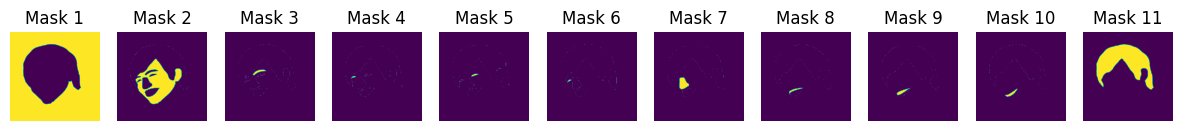

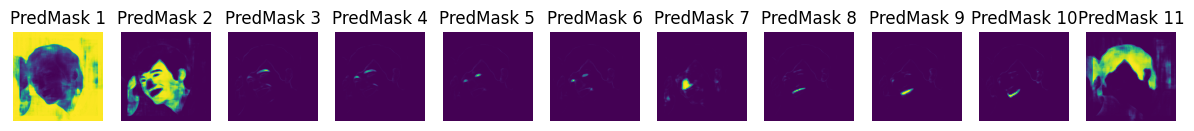

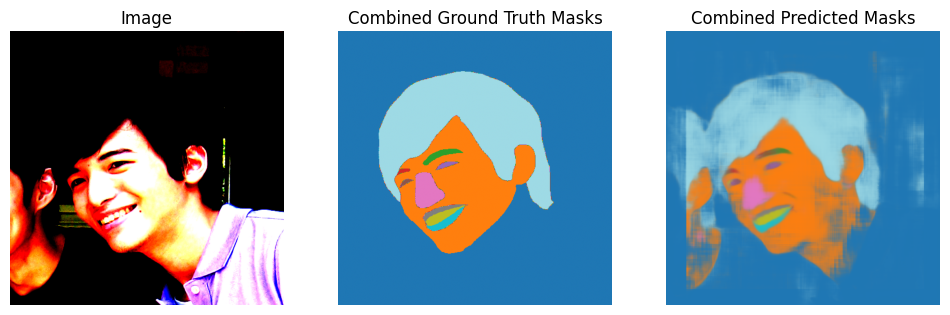

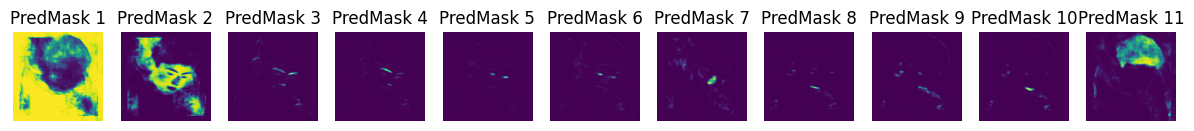

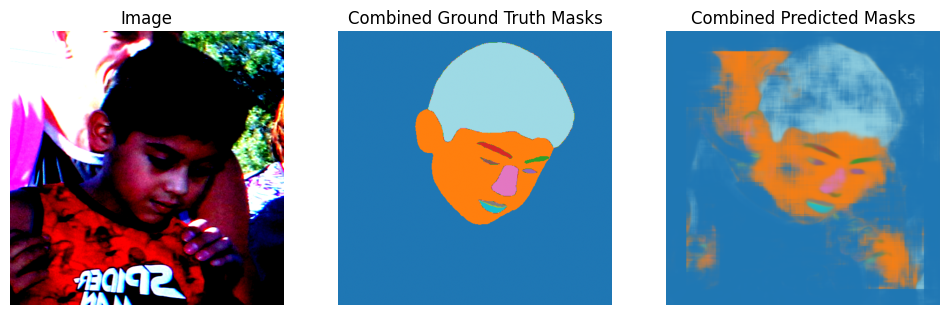

Saving weights-->
Epoch 1 ---> Train Loss = 0.06469992403251429  |  Val Loss = 0.07224457327808653
Minumum Loss: 0.07224457327808653


100%|██████████| 105/105 [00:36<00:00,  2.88it/s, loss=0.06]


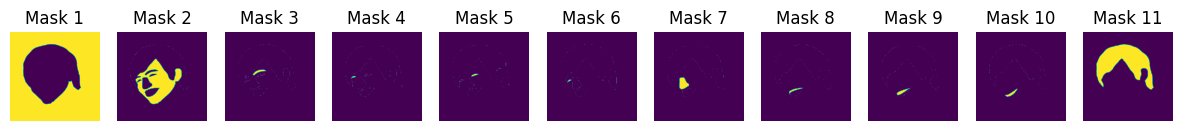

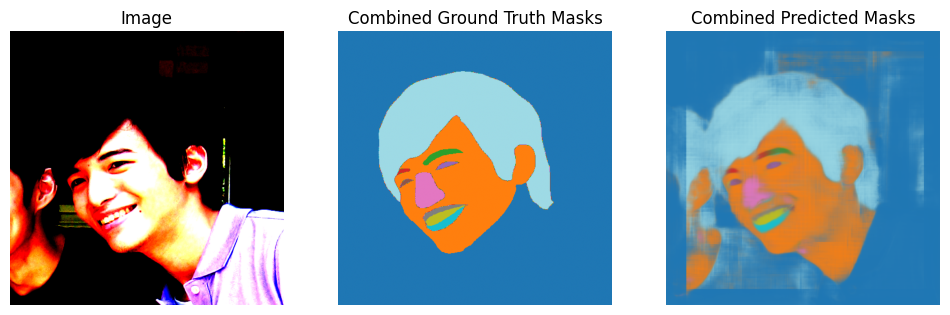

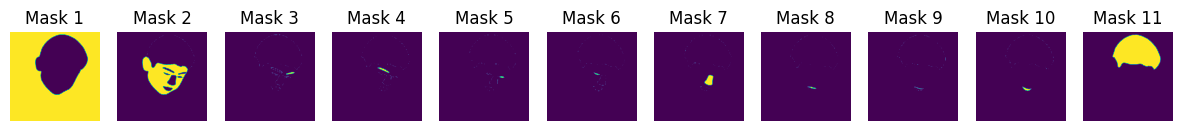

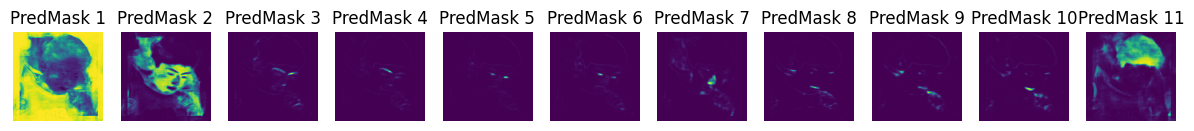

Epoch 2 ---> Train Loss = 0.06807495996045569  |  Val Loss = 0.0758873830238978
Minumum Loss: 0.07224457327808653


100%|██████████| 105/105 [00:37<00:00,  2.83it/s, loss=0.061]


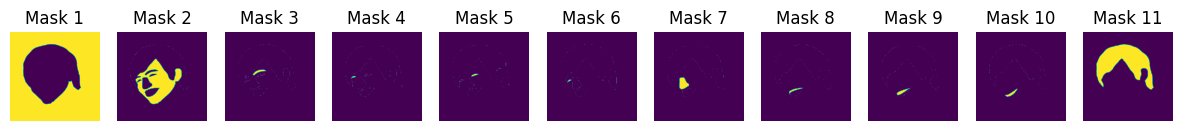

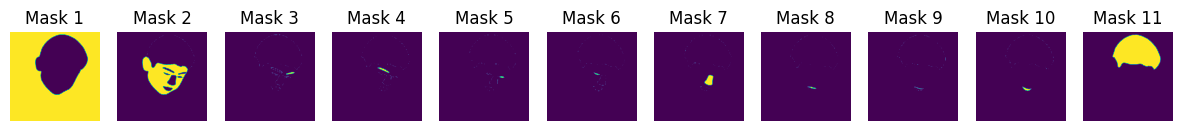

Epoch 3 ---> Train Loss = 0.06507634572374324  |  Val Loss = 0.07523973364205587
Minumum Loss: 0.07224457327808653


100%|██████████| 105/105 [00:37<00:00,  2.82it/s, loss=0.0547]


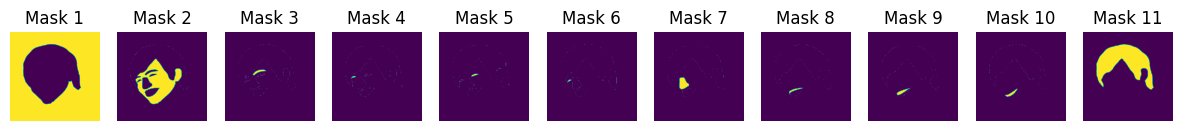

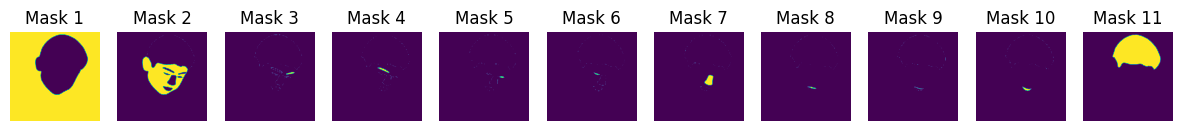

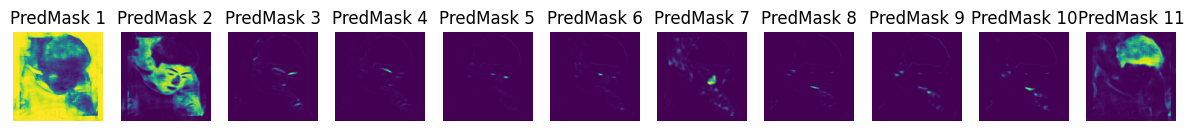

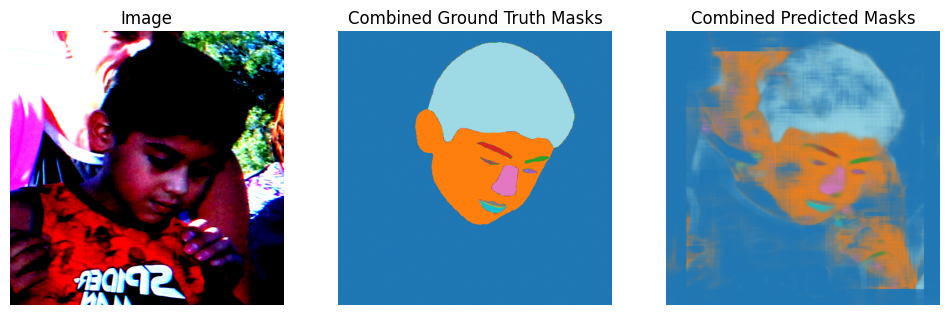

Epoch 4 ---> Train Loss = 0.06312389062096675  |  Val Loss = 0.07230050201926913
Minumum Loss: 0.07224457327808653
Early stopping at epoch 4


In [36]:
import pandas as pd
# Set CUDA_LAUNCH_BLOCKING to 1
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Ensure the change takes effect
print(f"CUDA_LAUNCH_BLOCKING is set to {os.environ['CUDA_LAUNCH_BLOCKING']}")
# Train the model and get the losses and ious/dices
train_losses, val_losses, train_ious, train_dices, val_ious, val_dices = train_loop(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs)

In [37]:
from google.colab import files

file_path = '/content/RESUNET.weights.pth.tar_4'
# Download the file
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

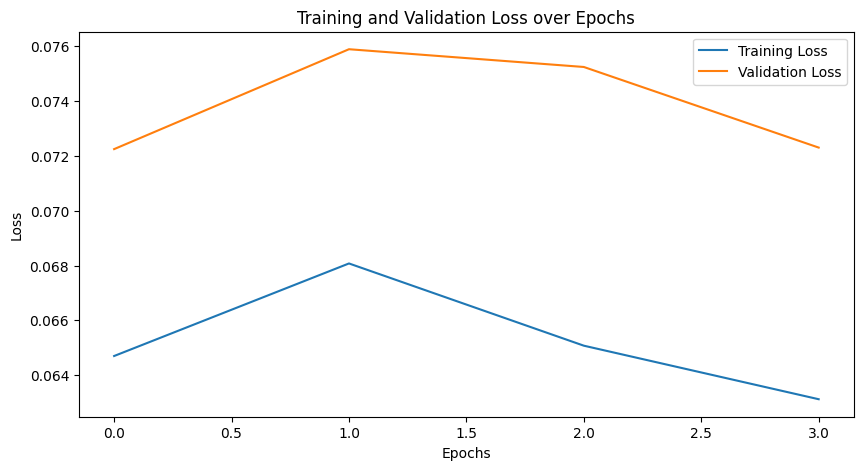

In [38]:
# Plot the losses

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

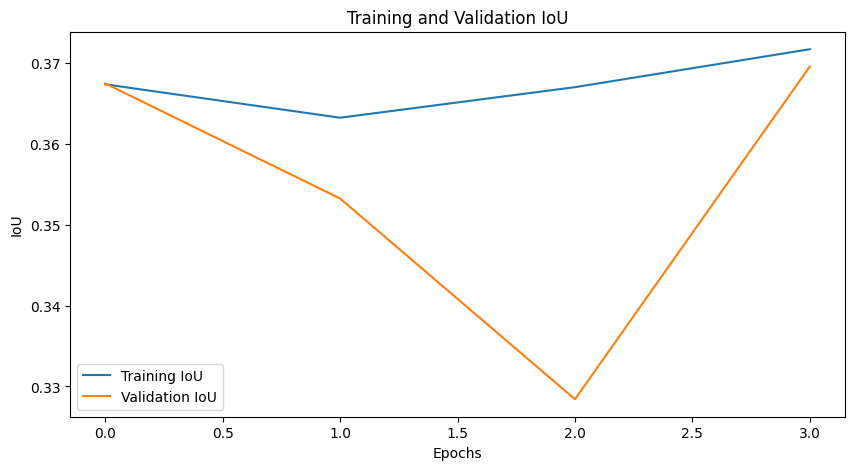

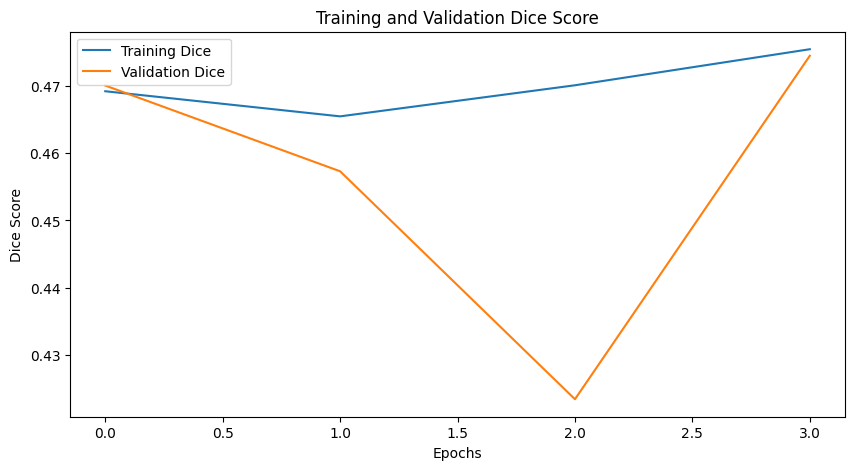

In [39]:
# Plot ious and dices

plt.figure(figsize=(10, 5))
plt.plot(train_ious, label='Training IoU')
plt.plot(val_ious, label='Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.title('Training and Validation IoU')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_dices, label='Training Dice')
plt.plot(val_dices, label='Validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.title('Training and Validation Dice Score')
plt.legend()
plt.show()


In [40]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [49]:
avg_iou, avg_dice, cm = test_loop(model, test_loader, criterion, device,11)

100%|██████████| 105/105 [00:43<00:00,  2.42it/s, loss=0.0612]


Test Loss: 0.0737
Mean IoU: 0.3696
Mean Dice: 0.4732


In [42]:
print('train_losses',train_losses)
print('val_losses',val_losses)
print('train_ious',train_ious)
print('train_dices',train_dices)
print('val_ious',val_ious)
print('val_dices',val_dices)

train_losses [0.06469992403251429, 0.06807495996045569, 0.06507634572374324, 0.06312389062096675]
val_losses [0.07224457327808653, 0.0758873830238978, 0.07523973364205587, 0.07230050201926913]
train_ious [0.36737484313547614, 0.3632453184078137, 0.367024865862396, 0.37171908194820086]
train_dices [0.4692517138024171, 0.4655088426421086, 0.4701398126780987, 0.4755109337779383]
val_ious [0.36747903653553554, 0.3532462883563269, 0.3284209364936465, 0.36958289188998084]
val_dices [0.4701007953711918, 0.45732659044719876, 0.42336854537328084, 0.4745338818856648]


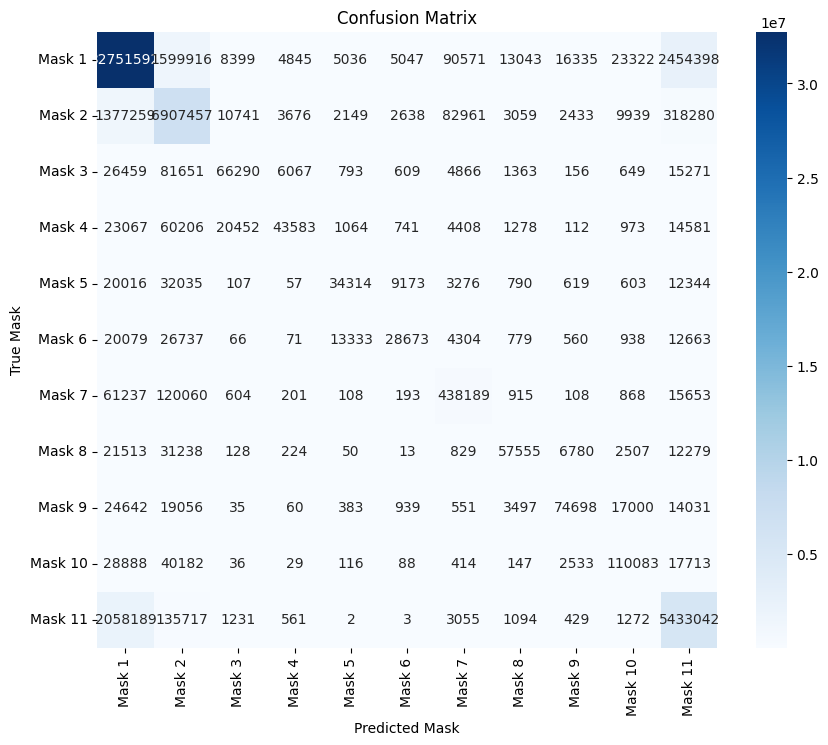

In [43]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[f'Mask {i+1}' for i in range(num_masks)], yticklabels=[f'Mask {i+1}' for i in range(num_masks)])
plt.xlabel('Predicted Mask')
plt.ylabel('True Mask')
plt.title('Confusion Matrix')
plt.show()

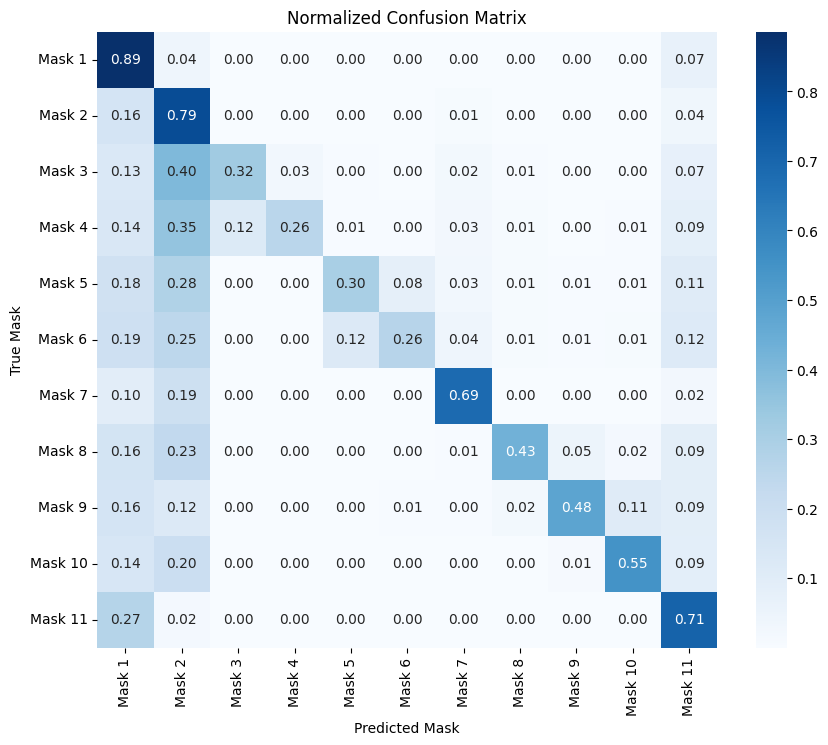

In [44]:
# Normalize the confusion matrix by row (true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=[f'Mask {i+1}' for i in range(num_masks)],
            yticklabels=[f'Mask {i+1}' for i in range(num_masks)])
plt.xlabel('Predicted Mask')
plt.ylabel('True Mask')
plt.title('Normalized Confusion Matrix')
plt.show()

In [45]:
def print_masks0(image,mask,pred,num_masks):
  with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        num_masks = 11
        fig, axes = plt.subplots(1, num_masks, figsize=(15, 15))
        fig1, axes1 = plt.subplots(1, num_masks, figsize=(15, 15))
        fig2, axes2 = plt.subplots(1,3,figsize=(12,4))

        # Display each mask
        for m in range(num_masks):
            axes[m].imshow(mask[0][m].cpu())
            axes[m].set_title(f'Mask {m + 1}')
            axes[m].axis('off')

        for m in range(num_masks):
            axes1[m].imshow(pred[0][m].detach().cpu().numpy())
            axes1[m].set_title(f'PredMask {m + 1}')
            axes1[m].axis('off')
        # for m in range(num_masks):
        #     binary_pred = (pred[0][m] > 0.0).float()
        #     axes2[m].imshow(binary_pred.detach().cpu().numpy(), cmap='viridis')
        #     axes2[m].set_title(f'Pred Mask {m + 1}')
        #     axes2[m].axis('off')

        colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors
        # Create combined masks with different colors
        combined_mask = np.zeros((512, 512, 3))
        combined_pred = np.zeros((512, 512, 3))
        combined_binary_pred = np.zeros((512, 512, 3))

        for m in range(num_masks):
            color = colors(m)[:3]  # Get RGB values from colormap
            combined_mask += np.stack([mask[0, m].cpu().numpy()] * 3, axis=-1) * color
            combined_pred += np.stack([pred[0, m].detach().cpu().numpy()] * 3, axis=-1) * color
            # binary_pred = (pred[0, m] > 0.0).float()
            # combined_binary_pred += np.stack([binary_pred.detach().cpu().numpy()] * 3, axis=-1) * color


        axes2[0].imshow(np.array(image[0].permute(1,2,0).cpu()))
        axes2[0].set_title('Image')
        axes2[0].axis('off')

        axes2[1].imshow(combined_mask)
        axes2[1].set_title('Combined Ground Truth Masks')
        axes2[1].axis('off')

        axes2[2].imshow(combined_pred)
        axes2[2].set_title('Combined Predicted Masks')
        axes2[2].axis('off')
plt.show()
plt.close(fig)

In [32]:
def print_masks1(image,mask,pred,num_masks):
    num_masks = 11
    fig, axes = plt.subplots(1, num_masks, figsize=(15, 15))
    fig1, axes1 = plt.subplots(1, num_masks, figsize=(15, 15))
    fig2, axes2 = plt.subplots(1,3,figsize=(12,4))

    # Display each mask
    for m in range(num_masks):
        axes[m].imshow(mask[1][m].cpu())
        axes[m].set_title(f'Mask {m + 1}')
        axes[m].axis('off')

    for m in range(num_masks):
        axes1[m].imshow(pred[1][m].detach().cpu().numpy())
        axes1[m].set_title(f'PredMask {m + 1}')
        axes1[m].axis('off')
    # for m in range(num_masks):
    #     binary_pred = (pred[0][m] > 0.0).float()
    #     axes2[m].imshow(binary_pred.detach().cpu().numpy(), cmap='viridis')
    #     axes2[m].set_title(f'Pred Mask {m + 1}')
    #     axes2[m].axis('off')

    colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors
    # Create combined masks with different colors
    combined_mask = np.zeros((512, 512, 3))
    combined_pred = np.zeros((512, 512, 3))
    combined_binary_pred = np.zeros((512, 512, 3))

    for m in range(num_masks):
        color = colors(m)[:3]  # Get RGB values from colormap
        combined_mask += np.stack([mask[1, m].cpu().numpy()] * 3, axis=-1) * color
        combined_pred += np.stack([pred[1, m].detach().cpu().numpy()] * 3, axis=-1) * color
        # binary_pred = (pred[0, m] > 0.0).float()
        # combined_binary_pred += np.stack([binary_pred.detach().cpu().numpy()] * 3, axis=-1) * color


    axes2[0].imshow(np.array(image[1].permute(1,2,0).cpu()))
    axes2[0].set_title('Image')
    axes2[0].axis('off')

    axes2[1].imshow(combined_mask)
    axes2[1].set_title('Combined Ground Truth Masks')
    axes2[1].axis('off')

    axes2[2].imshow(combined_pred)
    axes2[2].set_title('Combined Predicted Masks')
    axes2[2].axis('off')
plt.show()
plt.close(fig)

In [33]:
it = iter(test_loader)
image, mask = next(it)
image, mask = image.to(device), mask.to(device)
model.eval()
pred = model(image)

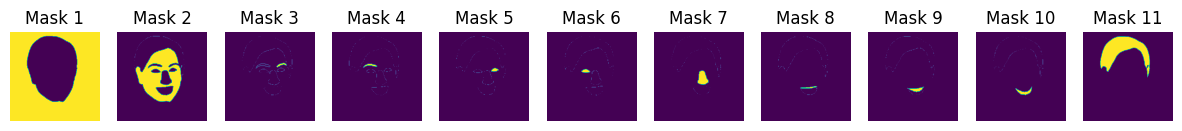

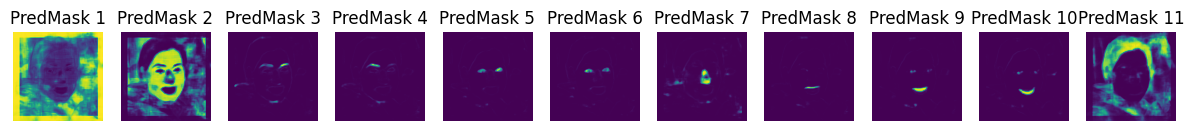

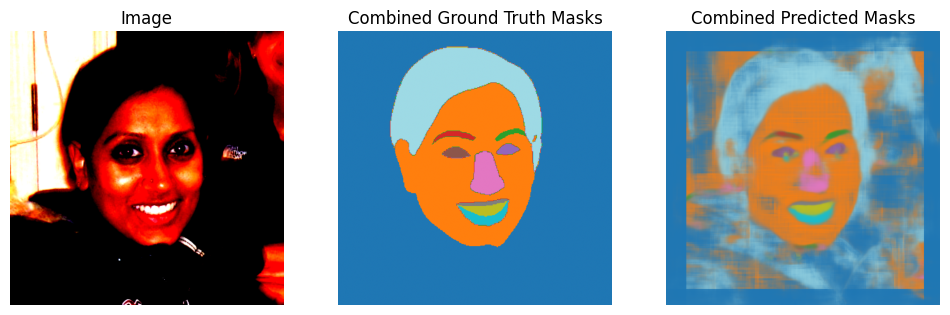

In [46]:
print_masks0(image,mask,pred,11)

<ipython-input-32-b69fc493c72f>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors


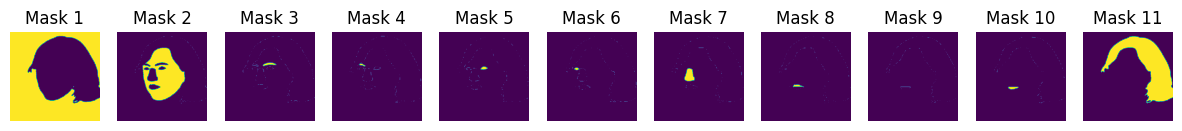

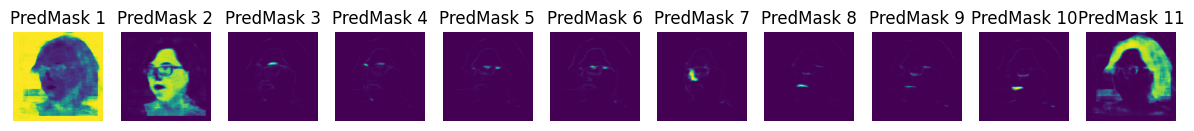

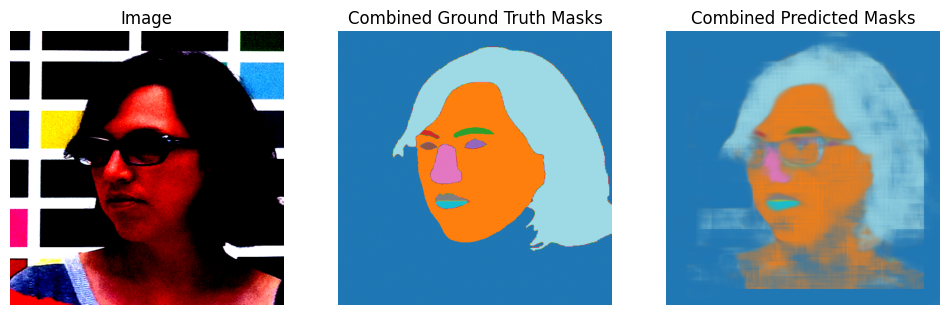

In [48]:
print_masks1(image,mask,pred,11)

In [ ]:
print(avg_iou, avg_dice)

0.09090909361839294 0.12479908329248428


In [ ]:
print(avg_iou, avg_dice)

0.09090909361839294 0.12479908329248428


In [ ]:
it = iter(val_loader)
image, mask = next(it)
image, mask = image.to(device), mask.to(device)
model.eval()
pred = model(image)

In [ ]:
mask[0][0].detach().cpu().numpy()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [ ]:
pred[0][0].detach().cpu().numpy()

array([[0.95913213, 0.9890324 , 0.9905861 , ..., 0.9897397 , 0.9899164 ,
        0.9554109 ],
       [0.9904455 , 0.99828464, 0.99884415, ..., 0.998591  , 0.9987476 ,
        0.9892904 ],
       [0.9887284 , 0.9981623 , 0.998569  , ..., 0.9988098 , 0.9989341 ,
        0.9906658 ],
       ...,
       [0.98212606, 0.99645704, 0.99793684, ..., 0.9965197 , 0.99643046,
        0.98130864],
       [0.9812027 , 0.9959187 , 0.9978321 , ..., 0.99562943, 0.9955776 ,
        0.9827952 ],
       [0.9460682 , 0.98408705, 0.98829854, ..., 0.98168886, 0.9826849 ,
        0.94362324]], dtype=float32)

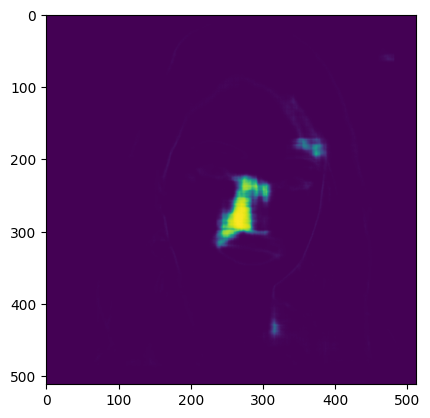

In [ ]:
plt.imshow(pred[0][6].detach().cpu().numpy())

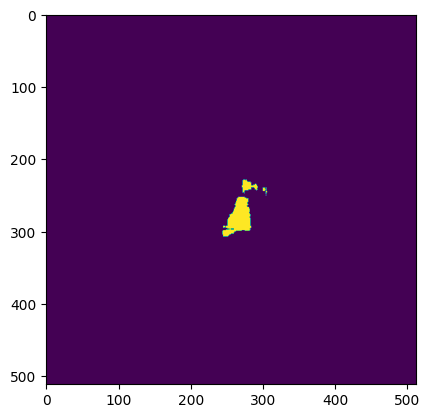

In [ ]:
plt.imshow(pred[0][6].detach().cpu().numpy() > 0.7)

<ipython-input-61-6d6a3a5bc32b>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors


(-0.5, 511.5, 511.5, -0.5)

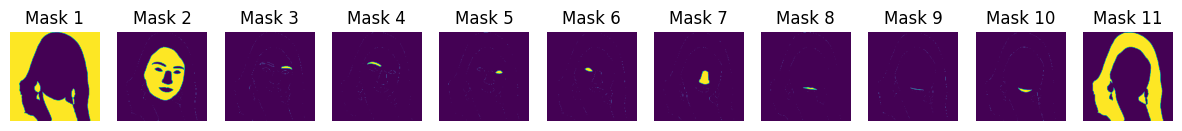

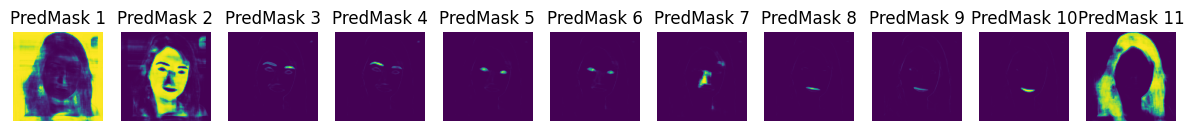

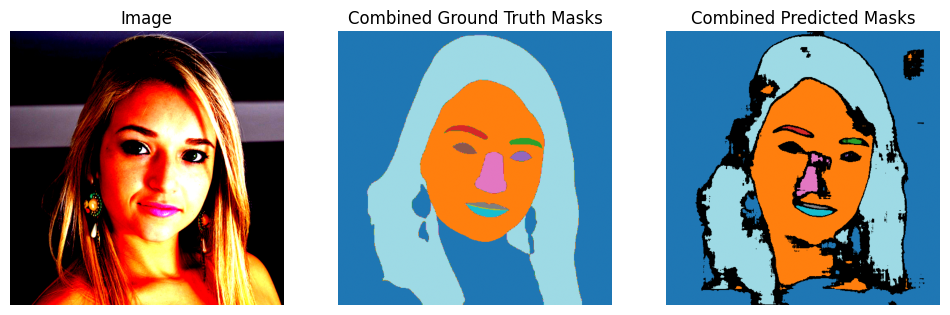

In [ ]:
    num_masks = 11
    fig, axes = plt.subplots(1, num_masks, figsize=(15, 15))
    fig1, axes1 = plt.subplots(1, num_masks, figsize=(15, 15))
    fig2, axes2 = plt.subplots(1,3,figsize=(12,4))

    # Display each mask
    for m in range(num_masks):
        axes[m].imshow(mask[0][m].cpu())
        axes[m].set_title(f'Mask {m + 1}')
        axes[m].axis('off')

    for m in range(num_masks):
        axes1[m].imshow(pred[0][m].detach().cpu().numpy())
        axes1[m].set_title(f'PredMask {m + 1}')
        axes1[m].axis('off')
    # for m in range(num_masks):
    #     binary_pred = (pred[0][m] > 0.0).float()
    #     axes2[m].imshow(binary_pred.detach().cpu().numpy(), cmap='viridis')
    #     axes2[m].set_title(f'Pred Mask {m + 1}')
    #     axes2[m].axis('off')

    colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors
    # Create combined masks with different colors
    combined_mask = np.zeros((512, 512, 3))
    combined_pred = np.zeros((512, 512, 3))
    combined_binary_pred = np.zeros((512, 512, 3))

    for m in range(num_masks):
        color = colors(m)[:3]  # Get RGB values from colormap
        combined_mask += np.stack([mask[0, m].cpu().numpy()] * 3, axis=-1) * color
        combined_pred += np.stack([pred[0, m].detach().cpu().numpy() > 0.7] * 3, axis=-1) * color
        # binary_pred = (pred[0, m] > 0.0).float()
        # combined_binary_pred += np.stack([binary_pred.detach().cpu().numpy()] * 3, axis=-1) * color


    axes2[0].imshow(np.array(image[0].permute(1,2,0).cpu()))
    axes2[0].set_title('Image')
    axes2[0].axis('off')

    axes2[1].imshow(combined_mask)
    axes2[1].set_title('Combined Ground Truth Masks')
    axes2[1].axis('off')

    axes2[2].imshow(combined_pred)
    axes2[2].set_title('Combined Predicted Masks')
    axes2[2].axis('off')


<ipython-input-40-f96f96ab80ef>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors


(-0.5, 511.5, 511.5, -0.5)

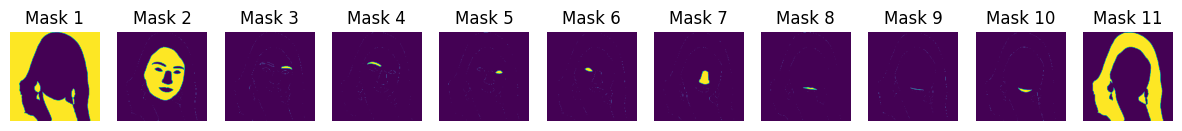

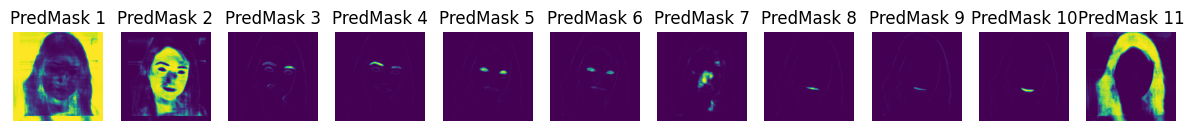

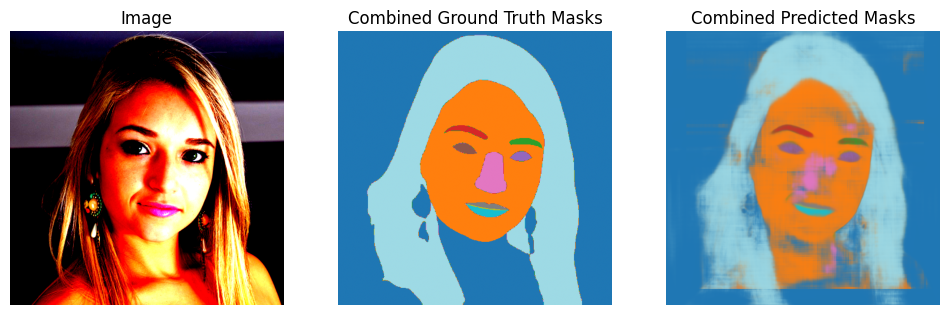

In [ ]:
    num_masks = 11
    fig, axes = plt.subplots(1, num_masks, figsize=(15, 15))
    fig1, axes1 = plt.subplots(1, num_masks, figsize=(15, 15))
    fig2, axes2 = plt.subplots(1,3,figsize=(12,4))

    # Display each mask
    for m in range(num_masks):
        axes[m].imshow(mask[0][m].cpu())
        axes[m].set_title(f'Mask {m + 1}')
        axes[m].axis('off')

    for m in range(num_masks):
        axes1[m].imshow(pred[0][m].detach().cpu().numpy())
        axes1[m].set_title(f'PredMask {m + 1}')
        axes1[m].axis('off')
    # for m in range(num_masks):
    #     binary_pred = (pred[0][m] > 0.0).float()
    #     axes2[m].imshow(binary_pred.detach().cpu().numpy(), cmap='viridis')
    #     axes2[m].set_title(f'Pred Mask {m + 1}')
    #     axes2[m].axis('off')

    colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors
    # Create combined masks with different colors
    combined_mask = np.zeros((512, 512, 3))
    combined_pred = np.zeros((512, 512, 3))
    combined_binary_pred = np.zeros((512, 512, 3))

    for m in range(num_masks):
        color = colors(m)[:3]  # Get RGB values from colormap
        combined_mask += np.stack([mask[0, m].cpu().numpy()] * 3, axis=-1) * color
        combined_pred += np.stack([pred[0, m].detach().cpu().numpy()] * 3, axis=-1) * color
        # binary_pred = (pred[0, m] > 0.0).float()
        # combined_binary_pred += np.stack([binary_pred.detach().cpu().numpy()] * 3, axis=-1) * color


    axes2[0].imshow(np.array(image[0].permute(1,2,0).cpu()))
    axes2[0].set_title('Image')
    axes2[0].axis('off')

    axes2[1].imshow(combined_mask)
    axes2[1].set_title('Combined Ground Truth Masks')
    axes2[1].axis('off')

    axes2[2].imshow(combined_pred)
    axes2[2].set_title('Combined Predicted Masks')
    axes2[2].axis('off')


<ipython-input-66-5e954e90d762>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors


(-0.5, 511.5, 511.5, -0.5)

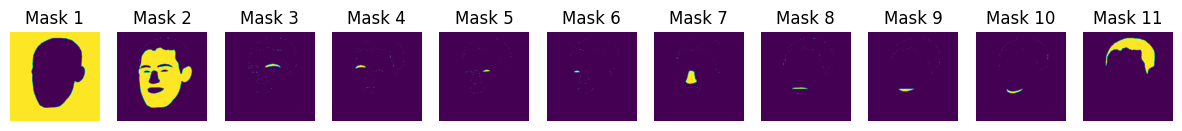

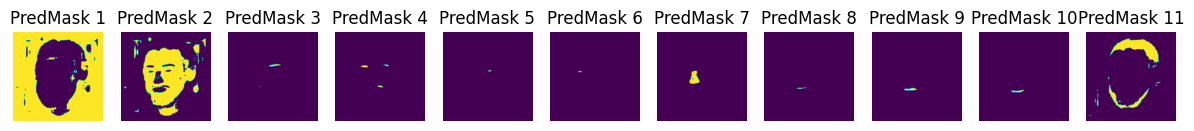

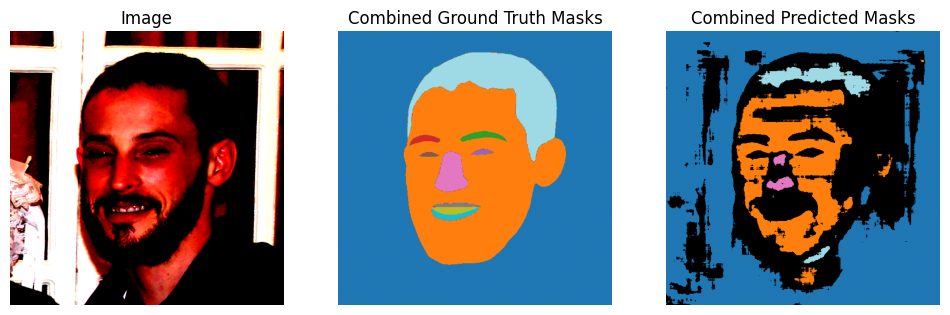

In [ ]:
    num_masks = 11
    fig, axes = plt.subplots(1, num_masks, figsize=(15, 15))
    fig1, axes1 = plt.subplots(1, num_masks, figsize=(15, 15))
    fig2, axes2 = plt.subplots(1,3,figsize=(12,4))

    # Display each mask
    for m in range(num_masks):
        axes[m].imshow(mask[1][m].cpu())
        axes[m].set_title(f'Mask {m + 1}')
        axes[m].axis('off')

    for m in range(num_masks):
        axes1[m].imshow(pred[1][m].detach().cpu().numpy() > 0.4)
        axes1[m].set_title(f'PredMask {m + 1}')
        axes1[m].axis('off')
    # for m in range(num_masks):
    #     binary_pred = (pred[0][m] > 0.0).float()
    #     axes2[m].imshow(binary_pred.detach().cpu().numpy(), cmap='viridis')
    #     axes2[m].set_title(f'Pred Mask {m + 1}')
    #     axes2[m].axis('off')

    colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors
    # Create combined masks with different colors
    combined_mask = np.zeros((512, 512, 3))
    combined_pred = np.zeros((512, 512, 3))
    combined_binary_pred = np.zeros((512, 512, 3))

    for m in range(num_masks):
        color = colors(m)[:3]  # Get RGB values from colormap
        combined_mask += np.stack([mask[1, m].cpu().numpy()] * 3, axis=-1) * color
        combined_pred += np.stack([pred[1, m].detach().cpu().numpy() > 0.9] * 3, axis=-1) * color
        # binary_pred = (pred[0, m] > 0.0).float()
        # combined_binary_pred += np.stack([binary_pred.detach().cpu().numpy()] * 3, axis=-1) * color


    axes2[0].imshow(np.array(image[1].permute(1,2,0).cpu()))
    axes2[0].set_title('Image')
    axes2[0].axis('off')

    axes2[1].imshow(combined_mask)
    axes2[1].set_title('Combined Ground Truth Masks')
    axes2[1].axis('off')

    axes2[2].imshow(combined_pred)
    axes2[2].set_title('Combined Predicted Masks')
    axes2[2].axis('off')


<ipython-input-35-b03bb19d5624>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors


(-0.5, 511.5, 511.5, -0.5)

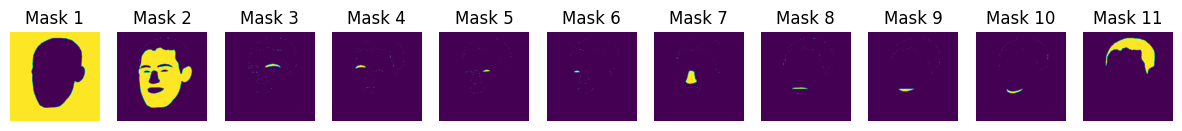

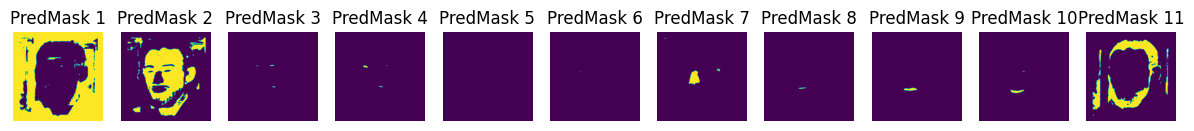

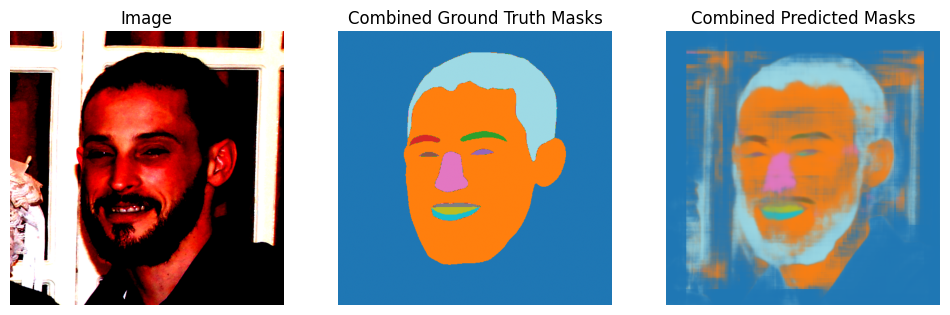

In [ ]:
    num_masks = 11
    fig, axes = plt.subplots(1, num_masks, figsize=(15, 15))
    fig1, axes1 = plt.subplots(1, num_masks, figsize=(15, 15))
    fig2, axes2 = plt.subplots(1,3,figsize=(12,4))

    # Display each mask
    for m in range(num_masks):
        axes[m].imshow(mask[1][m].cpu())
        axes[m].set_title(f'Mask {m + 1}')
        axes[m].axis('off')

    for m in range(num_masks):
        axes1[m].imshow(pred[1][m].detach().cpu().numpy() > 0.4)
        axes1[m].set_title(f'PredMask {m + 1}')
        axes1[m].axis('off')
    # for m in range(num_masks):
    #     binary_pred = (pred[0][m] > 0.0).float()
    #     axes2[m].imshow(binary_pred.detach().cpu().numpy(), cmap='viridis')
    #     axes2[m].set_title(f'Pred Mask {m + 1}')
    #     axes2[m].axis('off')

    colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors
    # Create combined masks with different colors
    combined_mask = np.zeros((512, 512, 3))
    combined_pred = np.zeros((512, 512, 3))
    combined_binary_pred = np.zeros((512, 512, 3))

    for m in range(num_masks):
        color = colors(m)[:3]  # Get RGB values from colormap
        combined_mask += np.stack([mask[1, m].cpu().numpy()] * 3, axis=-1) * color
        combined_pred += np.stack([pred[1, m].detach().cpu().numpy()] * 3, axis=-1) * color
        # binary_pred = (pred[0, m] > 0.0).float()
        # combined_binary_pred += np.stack([binary_pred.detach().cpu().numpy()] * 3, axis=-1) * color


    axes2[0].imshow(np.array(image[1].permute(1,2,0).cpu()))
    axes2[0].set_title('Image')
    axes2[0].axis('off')

    axes2[1].imshow(combined_mask)
    axes2[1].set_title('Combined Ground Truth Masks')
    axes2[1].axis('off')

    axes2[2].imshow(combined_pred)
    axes2[2].set_title('Combined Predicted Masks')
    axes2[2].axis('off')
